In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install nctoolkit
import nctoolkit as nc

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
import os
from tqdm import tqdm
from multiprocessing import Pool

##1. extract the 10x10 pixels value
- Dates, rainfall and temperature use the same dataframe for single pixel model
- Extract the 10x10 pixels NDVI and DEM value

In [ ]:
# Extract the 10x10 pixels NDVI value and save in csv file

dir_path = r'/content/drive/MyDrive/train/'

output_file = open('output_NDVI_10x10_raw.txt', 'w')

def process_file(file):
    with xr.open_dataset(file) as minicube:
        minicube = minicube.isel(time=slice(4, None, 5))
        nir = minicube.s2_B8A
        red = minicube.s2_B04
        mask = minicube.s2_mask

        ndvi = ((nir - red) / (nir + red + 1e-8)).where(mask == 0, np.NaN)
        minicube["s2_ndvi"] = ndvi

        ndvi_c = ndvi.isel(lat=slice(64-5, 64+5), lon=slice(64-5, 64+5))
        values = ndvi_c.values.reshape(ndvi_c.shape[0], -1)
        return ' '.join(' '.join(str(value) for value in row) for row in values) + '\n'

file_list = []
for subdir, dirs, files in os.walk(dir_path):
    for file in files:
        filepath = os.path.join(subdir, file)
        if filepath.endswith('.nc'):
            file_list.append(filepath)

with Pool() as p:
    results = list(tqdm(p.imap(process_file, file_list), total=len(file_list), desc='Processing files'))

# Write the results to the output file
output_file.writelines(results)
output_file.close()


In [ ]:
# Average the extracted 10x10 pixels NDVI value and save in a new csv file

with open('/content/drive/MyDrive/output_NDVI_10x10_raw.txt', 'r') as f:
    raw_ndvi_lines = f.readlines()

# Calculate the average NDVI value for each timestep
avg_ndvi_values = []
for line in raw_ndvi_lines:
    ndvi_values = np.array([float(value) for value in line.split()])
    ndvi_values_reshaped = ndvi_values.reshape(-1, 100)  # Reshape the flattened values into a 2D array with 30 rows (time steps) and 100 columns (pixels)
    avg_ndvi_per_timestep = np.nanmean(ndvi_values_reshaped, axis=1)  # Calculate the average NDVI value for each row (time step)
    avg_ndvi_values.append(avg_ndvi_per_timestep)

# Save the average NDVI values to a new file
with open('output_NDVI_10x10_avg.txt', 'w') as f:
    for avg_ndvi_per_timestep in avg_ndvi_values:
        f.write(' '.join(str(value) for value in avg_ndvi_per_timestep) + '\n')


Mean of empty slice


In [ ]:
# Extract the 10x10 pixels DEM value and save in csv file

dir_path = r'/content/drive/MyDrive/train/'

# Load all the netCDF files into a single xarray dataset
dataset = xr.open_mfdataset(os.path.join(dir_path, '**/*.nc'))

# Extract the time slice you want and flatten the data
dem_c = dataset['nasa_dem'].isel(lat=slice(64-5, 64+5), lon=slice(64-5, 64+5))

# Open the text file to save the data
output_file = open('output_dem_10x10_raw.txt', 'w')

# Loop through the flattened data, write it to the output file, and track progress with tqdm
with output_file as f, tqdm(desc='Processing data', total=len(dem_c.values.flatten())) as pbar:
    for value in dem_c.values.flatten():
        f.write(str(value) + ' ')
        pbar.update(1)

# Close the output file
output_file.close()

In [ ]:
# Average the extracted 10x10 pixels NDVI value and save in a new csv file

# Read the output file with 10x10 DEM values
with open('output_DEM_10x10_raw.txt', 'r') as f:
    raw_dem_lines = f.readlines()

# Calculate the average DEM value for each timestep
avg_dem_values = []
for line in raw_dem_lines:
    dem_values = np.array([float(value) for value in line.split()])
    avg_dem = np.nanmean(dem_values)
    avg_dem_values.append(avg_dem)

# Save the average DEM values to a new file
with open('output_DEM_10x10_avg.txt', 'w') as f:
    for avg_dem in avg_dem_values:
        f.write(str(avg_dem) + '\n')

# 2. Prepare the data and merge in one table

In [ ]:
# Load the tables of all values needed
dates_df = pd.read_csv('output_dates.txt',header=None, sep='\s')
ndvi_df_avg = pd.read_csv('output_NDVI_10x10_avg.txt',header=None, sep='\s')
ndvi_df = pd.read_csv('/content/drive/MyDrive/output_NDVI_10x10_raw.txt',header=None, sep='\s')
rainfall_df = pd.read_csv('output_rainfall.txt',header=None, sep='\s')
temp_df = pd.read_csv('output_temp.txt',header=None, sep='\s')
dem_df_avg = pd.read_csv('output_dem_10x10_avg.txt',header=None, sep='\s')
dem_df = pd.read_csv('output_dem_10x10_raw.txt',header=None, sep='\s')

In [ ]:
# let all dataframe has same length
common_indices = dates_df.index.intersection(rainfall_df.index).intersection(temp_df.index)

ndvi_df_avg = ndvi_df_avg.loc[common_indices]
ndvi_df = ndvi_df.loc[common_indices]
dem_df_avg = dem_df_avg.loc[common_indices]
dem_df = dem_df.loc[common_indices]


In [ ]:
# give each table the ID
dates_df = dates_df.rename_axis('Pixel_ID').reset_index()
ndvi_df_avg = ndvi_df_avg.rename_axis('Pixel_ID').reset_index()
rainfall_df = rainfall_df.rename_axis('Pixel_ID').reset_index()
temp_df = temp_df.rename_axis('Pixel_ID').reset_index()
dem_df_avg = dem_df_avg.rename_axis('Pixel_ID').reset_index()

dem_df_multi = dem_df.rename_axis('Pixel_ID').reset_index()
ndvi_df_multi = ndvi_df.rename_axis('Pixel_ID').reset_index()

In [ ]:
dem_df_multi

## 2.1 To prepare for the merged table with average pixel

In [ ]:
# to prepare for the merged table evg: dates, rainfall, temp, ndvi_avg, dem_avg

# add variable name to the column
for i in range(1,31):
    dates_df = dates_df.rename(columns={dates_df.columns[i]: f"Date {i}"})    
    rainfall_df = rainfall_df.rename(columns={rainfall_df.columns[i]: f"Rainfall {i}"})
    temp_df = temp_df.rename(columns={temp_df.columns[i]: f"Temperature {i}"})
    ndvi_df_avg = ndvi_df_avg.rename(columns={ndvi_df_avg.columns[i]: f"NDVI {i}"})

dem_df_avg = dem_df_avg.rename(columns={0: 'DEM'})

In [ ]:
#Add timesteps column and sort by pixel_ID for each table

#NDVI_avg
#add timesteps column
ndvi_df_avg = pd.melt(ndvi_df_avg, id_vars=['Pixel_ID'], var_name='Timestep', value_name='NDVI')
# Extract the timestep number from the 'Timestep' column
ndvi_df_avg['Timestep'] = ndvi_df_avg['Timestep'].str.extract('(\d+)', expand=False).astype(int)
# Sort by Pixel_ID and Timestep
ndvi_df_avg = ndvi_df_avg.sort_values(['Pixel_ID', 'Timestep']).reset_index(drop=True)

#Dates
#add timesteps column
dates_df = pd.melt(dates_df, id_vars=['Pixel_ID'], var_name='Timestep', value_name='Date')
# Extract the timestep number from the 'Timestep' column
dates_df['Timestep'] = dates_df['Timestep'].str.extract('(\d+)', expand=False).astype(int)
# Sort by Pixel_ID and Timestep
dates_df = dates_df.sort_values(['Pixel_ID', 'Timestep']).reset_index(drop=True)

#Rainfall
#add timesteps column
rainfall_df = pd.melt(rainfall_df, id_vars=['Pixel_ID'], var_name='Timestep', value_name='Rainfall')
# Extract the timestep number from the 'Timestep' column
rainfall_df['Timestep'] = rainfall_df['Timestep'].str.extract('(\d+)', expand=False).astype(int)
# Sort by Pixel_ID and Timestep
rainfall_df = rainfall_df.sort_values(['Pixel_ID', 'Timestep']).reset_index(drop=True)

#Temperature
#add timesteps column
temp_df = pd.melt(temp_df, id_vars=['Pixel_ID'], var_name='Timestep', value_name='Temperature')
# Extract the timestep number from the 'Timestep' column
temp_df['Timestep'] = temp_df['Timestep'].str.extract('(\d+)', expand=False).astype(int)
# Sort by Pixel_ID and Timestep
temp_df = temp_df.sort_values(['Pixel_ID', 'Timestep']).reset_index(drop=True)



In [ ]:
#Merge all veriable (avg) tables in one table
merged_table = pd.merge(dates_df, ndvi_df_avg, on=['Pixel_ID', 'Timestep'])
merged_table = pd.merge(merged_table, rainfall_df, on=['Pixel_ID', 'Timestep'])
merged_table = pd.merge(merged_table, temp_df, on=['Pixel_ID', 'Timestep'])
merged_table_avg = pd.merge(merged_table, dem_df_avg, on='Pixel_ID')

merged_table_avg

In [ ]:
merged_table_avg.to_csv('merged_table_avg.csv', index=False)

## 2.2 To prepare for the merged table with multiple pixels

In [ ]:
# reshape ndvi multi

# Get the number of pixels and timesteps
num_pixels = len(ndvi_df_multi)
num_timesteps = 30

# Drop the Pixel_ID column and reshape the ndvi_df_multi dataframe
ndvi_values = ndvi_df_multi.drop(columns=['Pixel_ID']).values.reshape(num_pixels, num_timesteps, -1)

# Create a new dataframe with reshaped NDVI values
ndvi_reshaped_df_list = []

for pixel_id in range(num_pixels):
    for timestep in range(num_timesteps):
        ndvi_timestep_values = ndvi_values[pixel_id, timestep, :]
        ndvi_timestep_df = pd.DataFrame(ndvi_timestep_values).T
        ndvi_timestep_df.columns = [f'NDVI_{i + 1}' for i in range(100)]
        ndvi_timestep_df['Pixel_ID'] = pixel_id
        ndvi_timestep_df['Timestep'] = timestep + 1
        ndvi_reshaped_df_list.append(ndvi_timestep_df)

ndvi_reshaped_df = pd.concat(ndvi_reshaped_df_list, ignore_index=True)


In [ ]:
ndvi_reshaped_df.head(35)

In [ ]:
merged_table_multi = pd.merge(dates_df, rainfall_df, on=['Pixel_ID', 'Timestep'])
merged_table_multi = pd.merge(merged_table_multi, temp_df, on=['Pixel_ID', 'Timestep'])
merged_table_multi = pd.merge(merged_table_multi, ndvi_reshaped_df, on=['Pixel_ID', 'Timestep'])
merged_table_multi = pd.merge(merged_table_multi, dem_df_multi, on=['Pixel_ID'])

merged_table_multi

In [ ]:
merged_table_multi.to_csv('merged_table_multi.csv', index=False)

# 3. Data preprocessing

## 3.1 Load and view the merged table

In [3]:
data_multi = pd.read_csv('/content/drive/MyDrive/merged_table_multi.csv')

In [26]:
data_avg = pd.read_csv('/content/drive/MyDrive/merged_table_avg.csv')


In [27]:
# statitics of the datasets
data_avg.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pixel_ID,714480.0,11907.500000,6875.091811,0.000000,5953.750000,11907.500000,17861.250000,23815.000000
Timestep,714480.0,15.500000,8.655448,1.000000,8.000000,15.500000,23.000000,30.000000
NDVI,456375.0,0.534985,0.215009,-0.995942,0.368159,0.556304,0.709173,0.999615
Rainfall,682470.0,1.393172,2.391656,0.000000,0.000000,0.200000,2.000000,65.400000
Temperature,698970.0,16.060864,6.060109,-13.400000,11.400000,16.200000,20.800000,33.000000
DEM,708390.0,316.170422,278.273777,-2.468250,118.887758,229.540202,402.153153,2200.214172


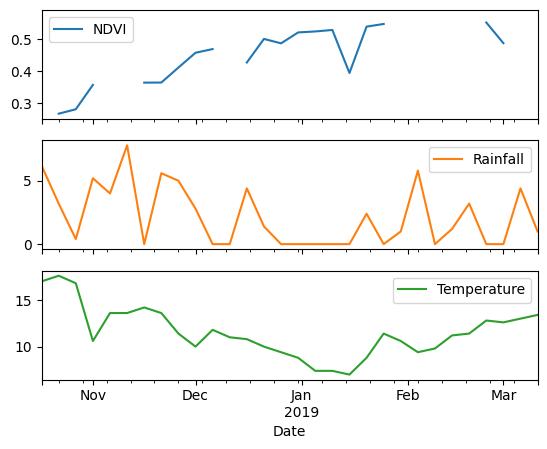

In [5]:
# view the data in timeseries of the first pixel (optional)
date_time = pd.to_datetime(data_avg.pop('Date'), format='%Y.%m.%d')

plot_cols = ['NDVI', 'Rainfall', 'Temperature']
plot_features = data_avg[plot_cols]
plot_features.index = date_time
_ = plot_features.iloc[:30].plot(subplots=True)

## 3.2 Data clean for table with average data

In [35]:
# Find the pixel with missing DEM values
unique_pixel_ids_with_missing_dem = data_avg.loc[data_avg['DEM'].isna(), 'Pixel_ID'].nunique()
print(f"Number of unique pixel IDs with missing DEM values: {unique_pixel_ids_with_missing_dem}")


Number of unique pixel IDs with missing DEM values: 203


In [36]:
# Remove the rows with missing DEM
data_avg_clean = data_avg.dropna(subset=['DEM'])

In [ ]:
# Find the pixel with missing NDVI values
missing_ndvi_counts = data_avg.groupby('Pixel_ID')['NDVI'].apply(lambda x: x.isna().sum()).reset_index(name='Missing_NDVI_Count')
missing_ndvi_counts

In [41]:
# Find the pixels with more than 50% missing NDVI values
missing_ndvi_counts['Missing_NDVI_Percentage'] = (missing_ndvi_counts['Missing_NDVI_Count'] / 30) * 100
pixels_with_over_50_percent_missing = missing_ndvi_counts[missing_ndvi_counts['Missing_NDVI_Percentage'] > 50].shape[0]
print(f"Number of pixels with more than 50% missing NDVI values: {pixels_with_over_50_percent_missing}")

Number of pixels with more than 50% missing NDVI values: 3103


In [42]:
# Remove the rows with more than 50% missing NDVI values

pixel_ids_to_remove = missing_ndvi_counts[missing_ndvi_counts['Missing_NDVI_Percentage'] > 50]['Pixel_ID'].tolist()
data_avg_clean = data_avg_clean[~data_avg_clean['Pixel_ID'].isin(pixel_ids_to_remove)]

In [ ]:
# Fill missing data for temp, rainfall and NDVI
data_avg_clean['Temperature'] = data_avg_clean['Temperature'].interpolate(method='pchip')
data_avg_clean['Rainfall'] = data_avg_clean['Rainfall'].interpolate(method='pchip')
data_avg_clean['NDVI'] = data_avg_clean['NDVI'].interpolate(method='pchip')

# Fill remaining missing values
data_avg_clean['NDVI'] = data_avg_clean['NDVI'].fillna(method='bfill')

In [50]:
has_nan = data_avg_clean.isna().any().any()
print("NaN values in the DataFrame:", has_nan)

NaN values in the DataFrame: False


In [ ]:
data_avg_clean

In [52]:
# statitics of the datasets
data_avg_clean.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pixel_ID,615390.0,11575.089504,6916.125703,0.000000,5603.000000,11434.000000,17503.000000,23697.000000
Timestep,615390.0,15.500000,8.655448,1.000000,8.000000,15.500000,23.000000,30.000000
NDVI,615390.0,0.538839,0.211279,-0.995942,0.378456,0.561304,0.707849,0.999615
Rainfall,615390.0,1.337114,2.359941,0.000000,0.000000,0.000000,1.800000,65.400000
Temperature,615390.0,16.113640,6.170675,-10.200000,11.200000,16.200000,21.000000,33.000000
DEM,615390.0,330.375438,284.567277,-2.468250,126.307393,241.645991,424.974665,2200.214172


In [53]:
# Get statistics for the NDVI column
ndvi_stats = data_avg_clean['NDVI'].describe()

# Print the statistics
print(ndvi_stats)

count    615390.000000
mean          0.538839
std           0.211279
min          -0.995942
25%           0.378456
50%           0.561304
75%           0.707849
max           0.999615
Name: NDVI, dtype: float64


In [54]:
data_avg_clean.to_csv('data_avg.csv', index=False)

## 3.3 Data clean for table with multiple pixels data

In [ ]:
data_multi

In [57]:
# Remove the rows with more than 50% missing NDVI value
data_multi_clean = data_multi[~data_multi['Pixel_ID'].isin(pixel_ids_to_remove)]

In [61]:
# Remove the rows with missing DEM values
data_multi_clean = data_multi_clean.dropna(subset=['DEM 1'])

In [ ]:
data_multi_clean

In [ ]:
# Fill missing data for temp, rainfall
data_multi_clean['Temperature'] = data_multi_clean['Temperature'].interpolate(method='pchip')
data_multi_clean['Rainfall'] = data_multi_clean['Rainfall'].interpolate(method='pchip')

# Fill missing data for NDVI
ndvi_columns = [f'NDVI_{i}' for i in range(1, 100+1)]

for column in ndvi_columns:
    data_multi_clean[column] = data_multi_clean[column].interpolate(method='pchip')
    data_multi_clean[column] = data_multi_clean[column].fillna(method='bfill')

# Fill missing data for DEM
dem_columns = [f'DEM {i}' for i in range(1, 100+1)]

for column in dem_columns:
    data_multi_clean[column] = data_multi_clean[column].interpolate(method='pchip')
    data_multi_clean[column] = data_multi_clean[column].fillna(method='bfill')

In [68]:
has_nan = data_multi_clean.isna().any().any()
print("NaN values in the DataFrame:", has_nan)

NaN values in the DataFrame: False


In [69]:
data_multi_clean.to_csv('data_multi.csv', index=False)